# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-07-27.ipynb)

## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 27. Paint-by-example

Paint-by-example [[Yang+ CVPR'23]](https://arxiv.org/abs/2211.13227) を用いてオリジナル画像に対して編集領域となるマスク画像と参照画像から画像編集を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Sat Jul 22 13:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00


## Paint-by-example を扱うパイプラインを構築

本セクションでは [`PaintByExamplePipeline`](https://huggingface.co/Fantasy-Studio/Paint-by-Example) を使用して Paint-by-example パイプラインの動作を確認します。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

動作確認のため Paint-by-example の本家レポジトリから元画像・マスク画像・参照画像の 3 つをダウンロードしてきます。今回はバケツの中に可愛い黒いわんちゃんを、パンダに変えてみようと思います。

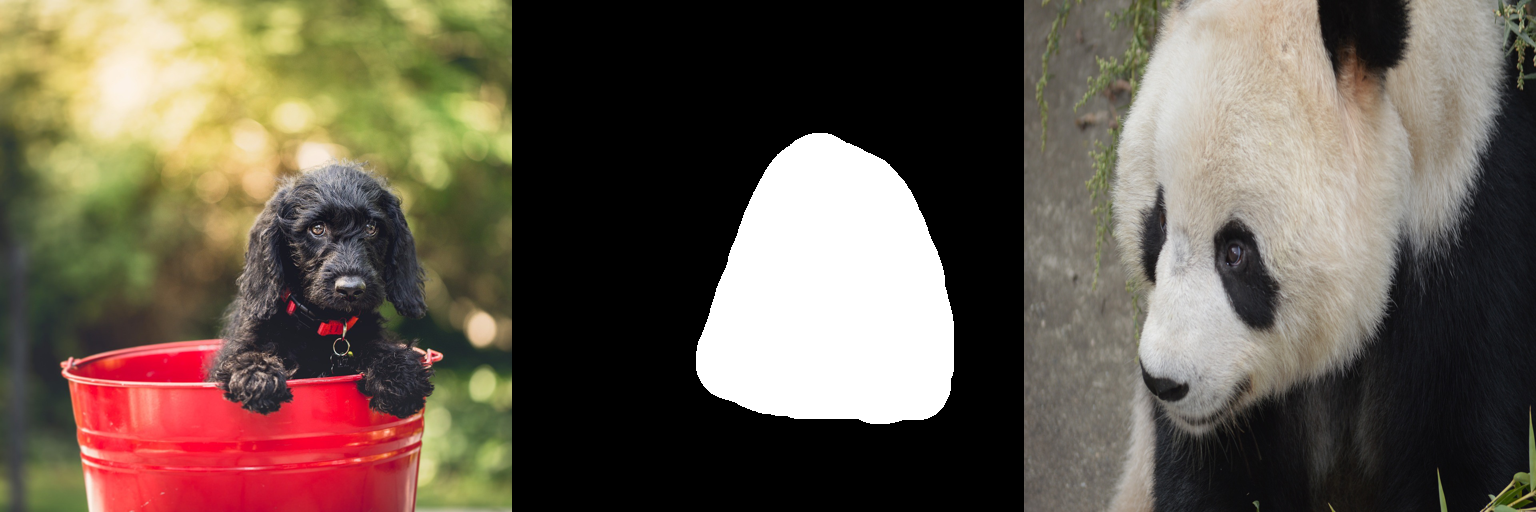

In [ ]:
from diffusers.utils import load_image

init_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/image/example_1.png")
mask_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/mask/example_1.png")
example_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/reference/example_1.jpg")

# ダウンロードした画像をそれぞれ 512 x 512 へリサイズしておきます
resize_size = (512, 512)
init_image = init_image.resize(resize_size)
mask_image = mask_image.resize(resize_size)
example_image = example_image.resize(resize_size)

image_grid([init_image, mask_image, example_image], rows=1, cols=3)

`PaintByExamplePipeline` を用いて、学習済みの `Fantasy-Studio/Paint-by-Example` を読み込みます。

In [ ]:
import torch
from diffusers import PaintByExamplePipeline

model_id = "Fantasy-Studio/Paint-by-Example"
pipe = PaintByExamplePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.


読み込んだパイプラインに対して、元画像 `init_image`、マスク画像 `mask_image`、参照画像 `example_image` を渡して画像を編集してみます。

  0%|          | 0/50 [00:00<?, ?it/s]

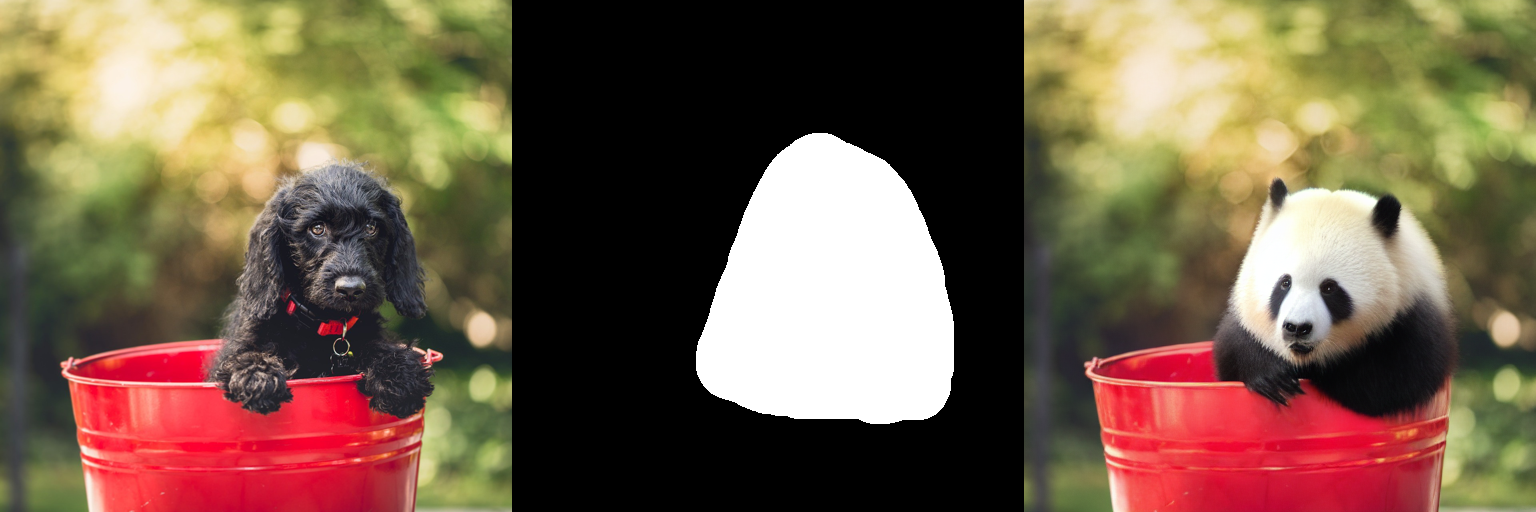

In [ ]:
edited_image = pipe(
    image=init_image,
    mask_image=mask_image,
    example_image=example_image,
).images[0]

image_grid([init_image, mask_image, edited_image], rows=1, cols=3)

以上のようにして、黒いわんちゃんの部分がパンダへと編集することができました。

次はわんちゃんの画像をねこちゃんに変化させてみましょう。以下のようにして使用する画像群をダウンロードします。

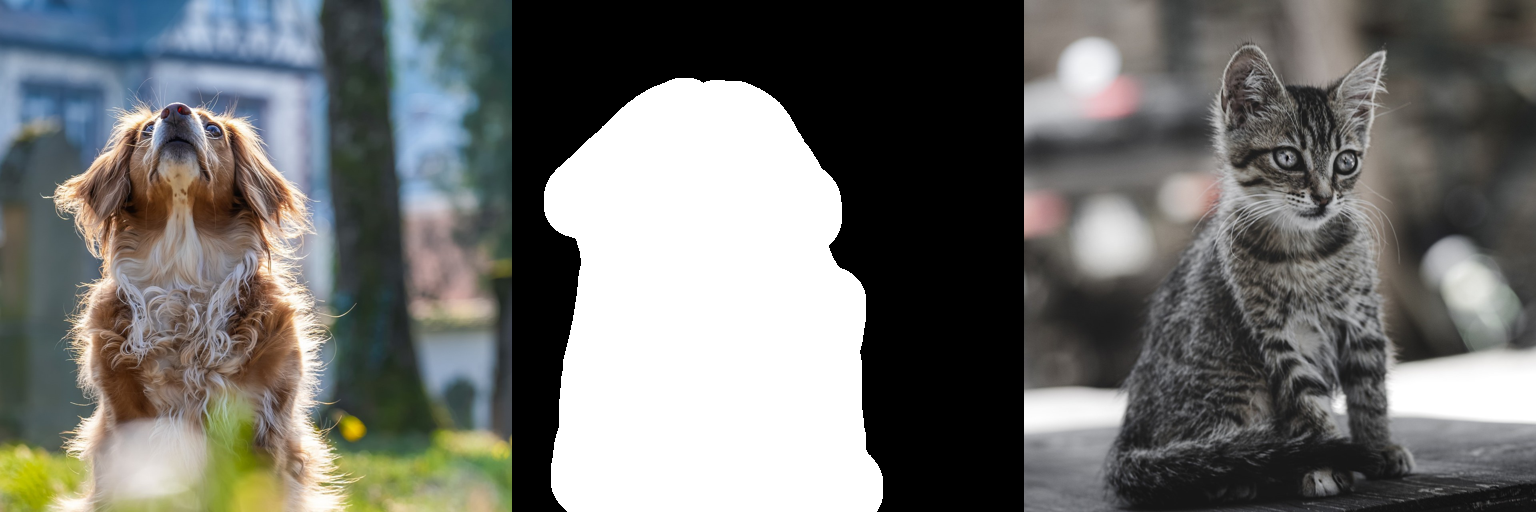

In [ ]:
from diffusers.utils import load_image

init_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/image/example_2.png")
mask_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/mask/example_2.png")
example_image = load_image("https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/reference/example_2.jpg")

# ダウンロードした画像をそれぞれ 512 x 512 へリサイズしておきます
resize_size = (512, 512)
init_image = init_image.resize(resize_size)
mask_image = mask_image.resize(resize_size)
example_image = example_image.resize(resize_size)

image_grid([init_image, mask_image, example_image], rows=1, cols=3)

同様にパイプラインに対して、元画像 `init_image`、マスク画像 `mask_image`、参照画像 `example_image` を渡して画像を編集してみます。

  0%|          | 0/50 [00:00<?, ?it/s]

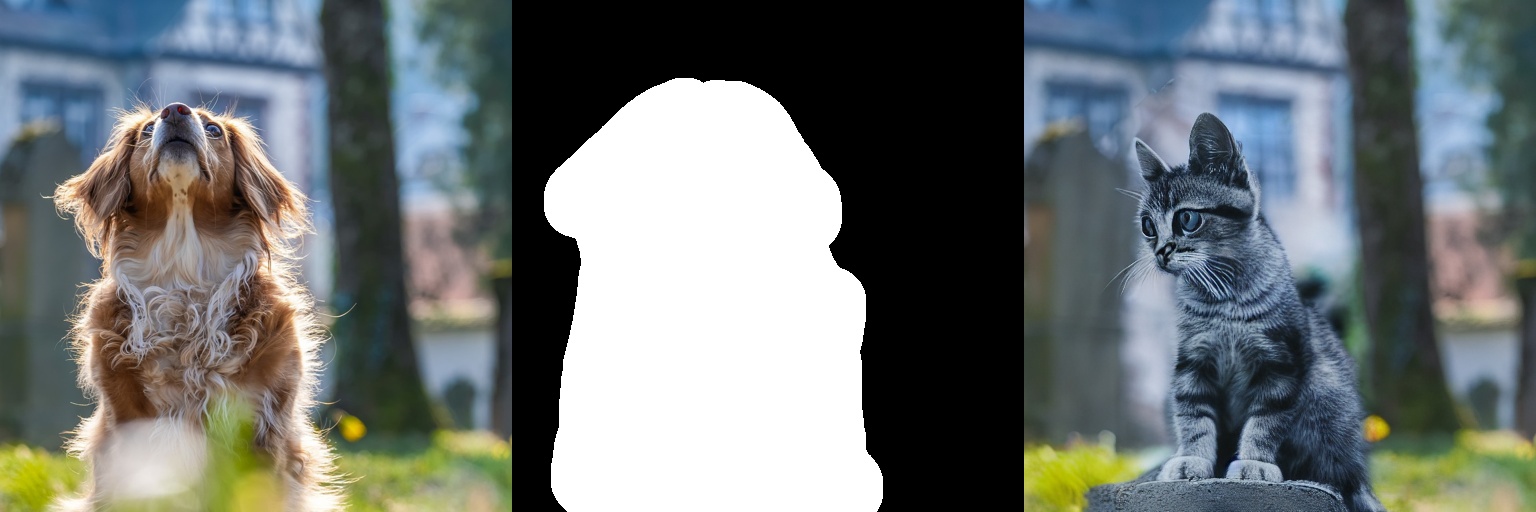

In [ ]:
edited_image = pipe(
    image=init_image,
    mask_image=mask_image,
    example_image=example_image,
).images[0]

image_grid([init_image, mask_image, edited_image], rows=1, cols=3)

以上のようにして、黒いわんちゃんの部分がねこちゃんへと編集することができました。